In [1]:
import numpy as np
import os
from soma import aims, aimsalgo
import pandas as pd
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
#b='_old'
b=''
directory = f'/volatile/jl277509/data/UkBioBank/crops/2mm{b}/CINGULATE/mask/'
side = 'R'

In [26]:
crops_dirs = directory+side+'crops/'
skel_subjects = pd.read_csv(directory+side+'skeleton_subject.csv')

distbottom_list = []
fm = aims.FastMarching()
for i, subject in enumerate(skel_subjects.Subject):
    vol = aims.read(crops_dirs+subject+'_cropped_skeleton.nii.gz')
    print(np.unique(vol.np))
    vol[vol.np > 30] = 100
    print(np.unique(vol.np))
    print(np.sum(vol.np>0))
    # carte de distance par FastMarching
    # propagation dans le label 100 (squelette) à partir de la graine 30 (bottom), sans graine extérieure (-1 n'existe pas dans l'image)
    dist = fm.doit(vol, 100, 30, -1)
    # convertir en np, modifier le type, puis reconvertir en vol int16
    arr_to_write = dist.np
    print(np.unique(arr_to_write))
    print(np.sum(arr_to_write<10000))
    outside = np.max(arr_to_write)
    inf_dist=2**15-1
    arr_to_write[arr_to_write==outside]=inf_dist
    arr_to_write = arr_to_write.astype(np.int16)
    arr_to_write = np.array(arr_to_write, order='F')
    print(np.sum(arr_to_write<10000))
    vol_to_write = aims.Volume(arr_to_write)
    #aims.write(vol_to_write, directory+side+f'distbottom/{subject}_cropped_distbottom.nii.gz')
    distbottom_list.append(arr_to_write)
    break

# Save all distance maps

In [4]:
distbottom_list = []
fm = aims.FastMarching()
for i, subject in enumerate(skel_subjects.Subject):
    vol = aims.read(crops_dirs+subject+'_cropped_skeleton.nii.gz')
    outside = 0
    other_outside = 11
    bottom_val = 30
    ss_val = 60

    # change all other values to ss_val
    vol_tmp = aims.Volume(vol)
    vol[vol.np != ss_val] = ss_val
    vol[vol_tmp.np == bottom_val] = bottom_val
    vol[vol_tmp.np == outside] = outside
    vol[vol_tmp.np == other_outside] = outside

    # propagation dans ss_val, avec outside non-atteignable
    aimsalgo.AimsDistanceFrontPropagation(vol, ss_val, outside, 3, 3, 3, 50, False)
    #aims.write(vol, directory+side+f'distbottom/{subject}_cropped_distbottom.nii.gz')
    break

In [5]:
subject

'sub-1000021'

# Save bool volumes to convert to buckets

In [6]:
save_dir='/volatile/jl277509/data/test_augmentations/trimdepth/volumes/'

In [86]:
#subject='sub-1000021'
subject='sub-2217188'
t_list = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
for k in t_list:
    vol = aims.read(crops_dirs+subject+'_cropped_skeleton.nii.gz')
    outside = 0
    other_outside = 11
    bottom_val = 30
    ss_val = 60

    # change all other values to ss_val
    vol_tmp = aims.Volume(vol)
    vol[vol.np != ss_val] = ss_val
    vol[vol_tmp.np == bottom_val] = bottom_val
    vol[vol_tmp.np == outside] = outside
    vol[vol_tmp.np == other_outside] = outside

    # propagation dans ss_val, avec outside non-atteignable
    aimsalgo.AimsDistanceFrontPropagation(vol, ss_val, outside, 3, 3, 3, 50, False)

    # threshold for visu
    arr = vol.np <= k
    arr = arr.astype(np.int16)
    arr = np.array(arr, order='F')
    vol = aims.Volume(arr)
    vol.header()['voxel_size'] = [2, 2, 2]
    aims.write(vol,save_dir+f'dist_{subject}_{k}.nii.gz')
vol = aims.read(crops_dirs+subject+'_cropped_skeleton.nii.gz')
aims.write(vol, save_dir+subject+'skel.nii.gz')

In [57]:
np.unique(vol)

array([    0,   100,   141,   173,   200,   241,   273,   282,   300,
         314,   341,   373,   382,   400,   414,   441,   446,   455,
         473,   482,   487,   514,   523,   541,   546,   573,   582,
         587,   614,   646,   682, 32500, 32501], dtype=int16)

# Check distance distribution

In [4]:
# load npy
arr = np.load(directory+side+'distbottom.npy')
print(arr.shape)

(21052, 16, 37, 37, 1)


In [78]:
for k in range(500, 2500, 100):
    a = np.sum(np.logical_and(arr >= k, arr<32000),axis=(1,2,3))
    print(k, np.sum(a))
    print(np.argmax(a), np.max(a))

500 385505
16711 181
600 101979
5117 128
700 28010
5117 123
800 13010
5117 118
900 7838
5117 114
1000 4811
5117 109
1100 2904
5117 106
1200 1811
5117 101
1300 1161
5117 98
1400 778
5117 94
1500 565
18539 91
1600 438
18539 87
1700 362
18539 85
1800 308
5117 82
1900 272
5117 80
2000 245
5117 77
2100 220
5117 75
2200 201
5117 72
2300 183
5117 69
2400 168
5117 66


In [27]:
# find corresponding subject to rank 5117
subjects = pd.read_csv('/volatile/jl277509/data/UkBioBank/crops/2mm/CINGULATE/mask/Rskeleton_subject.csv')
subjects = subjects['Subject'].tolist()
sub = subjects[5117]
print(sub)

sub-2217188


In [28]:
# save its bottom line
vol = aims.read(crops_dirs+sub+'_cropped_skeleton.nii.gz')
aims.write(vol, save_dir+sub+f'skel{b}.nii.gz')
vol[vol.np!=30]=0
aims.write(vol, save_dir+sub+f'skel{b}_bottom.nii.gz')

In [29]:
crops_dirs = directory+side+'labels/'
vol = aims.read(crops_dirs+sub+'_cropped_foldlabel.nii.gz')
vol[vol.np<7000]=0
vol[vol.np>=8000]=0
vol.header()['voxel_size'] = [2,2,2]
aims.write(vol, save_dir+sub+f'foldlabel{b}_bottom.nii.gz')

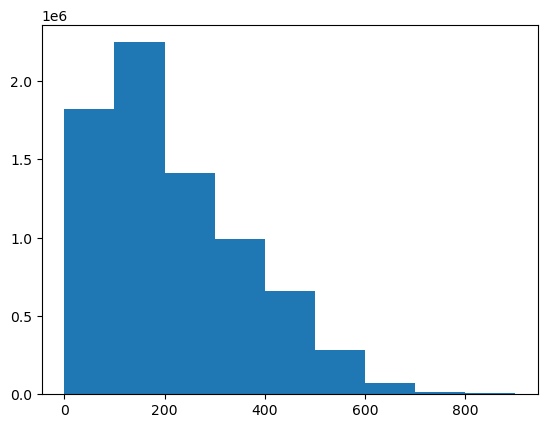

In [7]:
plt.hist(arr.flatten(), range=(0,1000), bins=range(0,1000,100))
plt.show()

In [8]:
# nb: 600 is like foldlabel 50...
# 300 seems the reasonable maximum ?
# proportion of voxels for each threshold
for k in range(0, 1000, 100):   
    print(k, np.sum(arr <= k)/np.sum(arr < 30000))

0 0.24236237909040248
100 0.389836520061877
200 0.5794976909031614
300 0.7451215389285233
400 0.8671556961596528
500 0.9502467841019363
600 0.986608101798193
700 0.9962863160523577
800 0.9982717474546134
900 0.9989587975825719


In [20]:
np.unique(arr, return_counts=True)

(array([    0,   100,   141,   173,   200,   241,   273,   282,   300,
          314,   341,   346,   373,   382,   400,   414,   423,   441,
          446,   455,   473,   482,   487,   500,   514,   519,   523,
          541,   546,   555,   564,   573,   582,   587,   596,   600,
          614,   619,   623,   628,   641,   646,   655,   660,   664,
          673,   682,   687,   692,   696,   700,   705,   714,   719,
          723,   728,   737,   741,   746,   755,   760,   764,   769,
          773,   782,   787,   792,   796,   801,   805,   814,   819,
          823,   828,   833,   837,   841,   846,   855,   860,   864,
          865,   869,   873,   878,   882,   887,   892,   896,   901,
          905,   910,   914,   919,   923,   928,   933,   937,   942,
          946,   955,   960,   964,   965,   969,   974,   978,   982,
          987,   992,   996,  1001,  1005,  1006,  1010,  1014,  1019,
         1023,  1028,  1033,  1037,  1042,  1046,  1051,  1055,  1060,
      

# Obsolete

In [8]:
aims.write(vol, save_dir+'skel.nii.gz')

In [9]:
arr_to_write = dist.np
outside = np.max(arr_to_write)
inf_dist=2**15-1
arr_to_write[arr_to_write==outside]=inf_dist
arr_to_write = arr_to_write < 10000
arr_to_write = arr_to_write.astype(np.int16)
arr_to_write = np.array(arr_to_write, order='F')
d = aims.Volume(arr_to_write)
vs = vol.header()['voxel_size']
d.header()['voxel_size'] = vs
aims.write(d, save_dir+'dist_no_inf.nii.gz')

In [10]:
arr1 = vol.np == 30 # bottom voxels
arr2 = dist.np == 0 # voxels with distance 0 to bottom
np.sum(arr1!=arr2) # difference
# certains bottoms n'ont pas une distance nulle aux bottoms (4)

4

In [79]:
arr3=(arr1!=arr2).astype(np.int16)
arr3=np.array(arr3, order='F')
vol3 = aims.Volume(arr3)
vs = vol.header()['voxel_size']
vol3.header()['voxel_size'] = vs
aims.write(vol3, save_dir+'weird_bottoms.nii.gz')

In [80]:
np.sum(vol3)

4

In [13]:
print(np.sum(vol.np>0))
print(np.sum(arr_to_write<10000))

376
297


In [43]:
arr_distbottom_all = np.stack(distbottom_list)

In [44]:
arr_distbottom_all.shape

(21052, 16, 37, 37, 1)

In [54]:
np.random.randint(0,1)

0

In [45]:
np.save(directory+side+'distbottom.npy', arr_distbottom_all)

In [32]:
a = np.load('/volatile/jl277509/data/UkBioBank/crops/2mm/CINGULATE/mask/Rskeleton.npy')

In [33]:
a.shape

(21052, 16, 37, 37, 1)

In [29]:
b = np.load('/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE/mask/Rskeleton.npy')

In [30]:
b.shape

(341, 16, 37, 37, 1)